# Low Level Neural Network for ECG Classification

In this notebook we implement a 3-layer ANN for classifying ECG signals using PSD and Energy as input.
Our three layers consist of:
Layer 1: 2 neurons to input the PSD and Energy.
Layer 2: In Layer 2 we used a variable amount of neurons ,namely from one to 30 neurons and we obtained the best metrics by using  a 16 neuron layer.
Layer 3: 2 neurons to output the probability of a patient having a Normal sinus or an arrythmia.

The Network is implemented from scratch to mimic the flow of the process on low-level hardware.

In [2]:
# Library imports
import numpy as np
import matplotlib
import csv
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

## Loading datasets

We load the arrythmia and  normal sinus datasets from https://physionet.org/physiobank/database/#ecg MIT-BIH and split the data into two sets, a training set and a post-training test set.
We also perform normalization of data to decrease the training speed when using the gradient descent optimization.

[0 0 1 1 0 0 0 1 1 0 0]
[[1.49364294e-03 2.98558157e-01]
 [5.88622089e-04 1.31272587e-01]
 [6.59792692e-03 1.06531609e-02]
 [2.16364689e-02 1.12378399e-02]
 [2.45044572e-03 3.64859395e-01]
 [3.88817167e-05 1.41916518e-01]
 [8.91711873e-03 4.68797725e-01]
 [1.00000000e+00 8.09837526e-02]
 [7.18320279e-03 3.70856311e-03]
 [0.00000000e+00 1.25290164e-01]
 [5.96417470e-04 3.93524039e-02]]


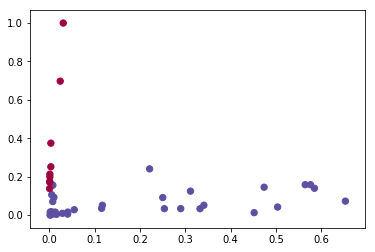

In [11]:
# Load dataset and plot a scatter-graph
np.random.seed(0)
X1_init= []
y_init= []
max1 = 0
max2 = 0
min1 = 99999999
min2 = 99999999

with open('database.csv', 'rt') as csvfile:
    lines = csv.reader(csvfile)
    for row in lines:
        dummy = []
        dummy.append(float(row[1])*1e10)
        dummy.append(float(row[2])/1e5)
        max1 = max(max1, dummy[0])
        max2 = max(max2, dummy[1])
        min1 = min(min1, dummy[0])
        min2 = min(min2, dummy[1])
        X1_init.append(dummy)
        y_init.append(int(row[3]))

X_init = []
for val in X1_init:
    dumbo = []
    v1 = (val[0]- min1)/(max1-min1)
    v2 = (val[1]- min2)/(max2-min2)
    dumbo.append(v1)
    dumbo.append(v2)
    X_init.append(dumbo)
Xt = np.array(X_init[len(X_init)-11:])
yt = np.array(y_init[len(X_init)-11:])
X = np.array(X_init[0:len(X_init)-12])
y = np.array(y_init[0:len(X_init)-12])
print (yt)
print(Xt)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

There are two labels (healthy sinus and arrythmia) denoted as red and blue points in the above graph

Our goal is to train an ML classifier that predicts if the patient is healthy or not.

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = -2, 4
    y_min, y_max = 0, 50
    h = 0.1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.ylim(0,2)
    plt.xlim(-0.1,1)

## Network Architecture and Training

Firstly, we will build our 3 layer network, with one input layer (dimensionality = 2 ; PSD & Energy), hidden layer (dimensionality = 16 ; which corrosponds to the perceptrons) and the output layer which takes from the hidden layer the inputs and maps them to our classes(2: Normal Wave or not). Furthermore, if we need to expand our network, our architecture is modular and can be scaled to occupy more classes and feautures.

<img src='http://www.vilipetek.com/wp-content/uploads/2015/02/Multilayer-Perceptron-Creation.png' style='width: 50%'/>

The choice of the number of perceptrons in the hidden layer reflects the complexity and the ability to comprehend more feautures. Moreover, there is a tradeoff for chosing high dimensionality in the hidden layer, which is the computional cost.
In spiderman, there was a saying "With great power comes great responsibility"; and that exactly what happens with a neural network with more power(perceptrons), comes greater responsibility(computional cost).

Secondly, in order to transfer the output of the layers to closer values, we need activation functions and specially non-linear activiation functions. Some of the most important and used activation functions are the tanh,RELU, sigmoid and softmax.

### ANN's Prediction

Our network makes predictions using *forward propagation*, which is basically matrix multiplications and the application of the activation functions we mentioned earlier. If $x$ is the 2-dimensional input(PSD & Energy) to our network, then we compute our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The equation basically calculates the error by summing the values of the test data and approximates the error, by checking the wrongly classified points.

Our objective is to minimize the loss function mentioned earlier, thus we will use a simple gradient descent algorithm. Moreover, we will need to define the below equation to be used.

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [5]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [6]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [7]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    print("Probs: \n",probs)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 20000 iterations
def build_model(nn_hdim, num_passes=300, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(1)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        best = 1000
        losses=calculate_loss(model)
        if best>losses:
            best = losses
            BW1 = W1
            Bb1 = b1
            BW2 = W2
            Bb2 = b2
        W1A = []
        W2A = []
        b1A = []
        b2A = []
        for i in Bb1:
            for j in i:
                b1A.append(j)
        for i in Bb2:
            for j in i:
                b2A.append(j)
        for j in BW1:
            for i in j:
                W1A.append(i)
        for j in BW2:
            for i in j:
                W2A.append(i)
        b1A = np.array(b1A)
        b2A = np.array(b2A)
        W2A = np.array(W2A)
        W1A = np.array(W1A)
        np.savetxt("bestWeights/BW1.csv", W1A)
        np.savetxt("bestWeights/b1.csv", b1A)
        np.savetxt("bestWeights/BW2.csv", W2A)
        np.savetxt("bestWeights/b2.csv", b2A)
#     print ("Weights of edges of Input layer to hidden layer (2x16): ",W1, "\n")
#     print ("biases of hidden layer (x16): ",b1, "\n")
#     print ("Weights of edges of hidden layer to output layer (16x2): ",W2, "\n")
#     print ("biases of output layer (x2): ",b2, "\n")
    print(best)
    return model

### Selected hidden layer neurons size(16)

Based on the hidden layer neurons count variant training we chose 16.


In [9]:
# Build a model with a 16-dimensional hidden layer
model = build_model(16, print_loss=True)

0.08991451839856202


[0.00149364 0.29855816]
Probs: 
 [[0.99025768 0.00974232]]
[0] 0
[0.00058862 0.13127259]
Probs: 
 [[0.42729769 0.57270231]]
[1] 0
[0.00659793 0.01065316]
Probs: 
 [[0.01676229 0.98323771]]
[1] 1
[0.02163647 0.01123784]
Probs: 
 [[0.01233397 0.98766603]]
[1] 1
[0.00245045 0.36485939]
Probs: 
 [[0.99831306 0.00168694]]
[0] 0
[3.88817167e-05 1.41916518e-01]
Probs: 
 [[0.51095393 0.48904607]]
[0] 0
[0.00891712 0.46879773]
Probs: 
 [[9.99845521e-01 1.54479291e-04]]
[0] 0
[1.         0.08098375]
Probs: 
 [[2.55431063e-07 9.99999745e-01]]
[1] 1
[0.0071832  0.00370856]
Probs: 
 [[0.0135336 0.9864664]]
[1] 1
[0.         0.12529016]
Probs: 
 [[0.38652375 0.61347625]]
[1] 0
Probs: 
 [[9.99999513e-01 4.87095146e-07]
 [9.99999480e-01 5.20195024e-07]
 [9.99999433e-01 5.67242729e-07]
 ...
 [9.99999999e-01 6.25333898e-10]
 [9.99999999e-01 6.25333914e-10]
 [9.99999999e-01 6.25333934e-10]]


Text(0.5,1,'Decision Boundary for hidden layer size 16')

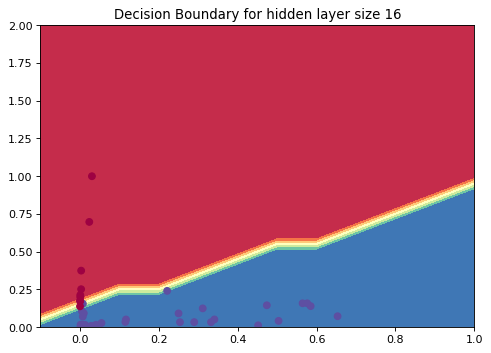

In [13]:
scores = 0
for i in range(0, 10, 1):
    print(Xt[i])
    t = predict(model,Xt[i])
    if t == yt[i]:
        scores+=1
    print (t,yt[i])
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 16")

###### Varying the hidden layer size

In the example above we picked a hidden layer size of 16. Let's now get a sense of how varying the hidden layer size affects the result.


Model 1 With 1 perceptrons
 Loss = 0.09983589374395352


Probs: 
 [[0.99782367 0.00217633]
 [0.99782275 0.00217725]
 [0.99782116 0.00217884]
 ...
 [0.99782494 0.00217506]
 [0.99782494 0.00217506]
 [0.99782494 0.00217506]]


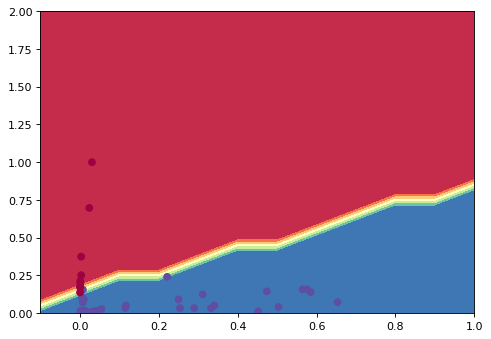

Model 2 With 16 perceptrons
 Loss = 0.08991451839856202


Probs: 
 [[9.99999513e-01 4.87095146e-07]
 [9.99999480e-01 5.20195024e-07]
 [9.99999433e-01 5.67242729e-07]
 ...
 [9.99999999e-01 6.25333898e-10]
 [9.99999999e-01 6.25333914e-10]
 [9.99999999e-01 6.25333934e-10]]


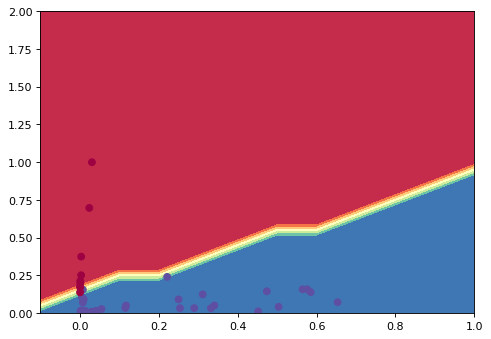

Model 3 With 2000 perceptrons
 Loss = 

KeyboardInterrupt: 

In [11]:
hidden_layer_dimensions = [1,16,2000]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    print("Model",i+1,"With %d perceptrons\n Loss = "%nn_hdim,end="")
    model = build_model(nn_hdim, print_loss=True)
    print('\n')
    plot_decision_boundary(lambda x: predict(model, x))
    plt.show()
